# Analysis Workflow: Reduction and Export

GBM was designed with high temporal and spectral resolution primarily to study GRB spectra and spectral evolution throughout a GRB.  So, ideally we would like to reduce the data and model the background so that we can get at the thing we're really interested in: the source spectrum.  The following workflow will show you how you can do this and export the relevant data so that it can be used with [XSPEC](https://heasarc.gsfc.nasa.gov/xanadu/xspec/) to fit the source spectrum.

To start, we need to be able to read in some data.  Let's use TTE. Because we're using TTE, we'll need a binning algorithm.  And we need some response files.  Luckily these are already generated for us if it's a GRB that was triggered onboard GBM.   

In [1]:
from gbm import test_data_dir
from gbm.data import TTE
from gbm.binning.unbinned import bin_by_time

# open a TTE file
tte = TTE.open(test_data_dir+'/glg_tte_n9_bn090131090_v00.fit')
# bin to 1.024 s resolution, reference time is trigger time
phaii = tte.to_phaii(bin_by_time, 1.024, time_ref=0.0)

Of course we'll want to visualize what we're doing, so we need some classes from the ```gbm.plot``` module. Also, what we're going to do here is set the energy range we're interested in.  Generally, for the NaIs, you don't want to go below 8 keV.  Yes, GBM data goes below that, but the response is poorly calibrated below 8 keV. And you don't want to include the overflow channel, so going up to ~900 keV should be sufficient.

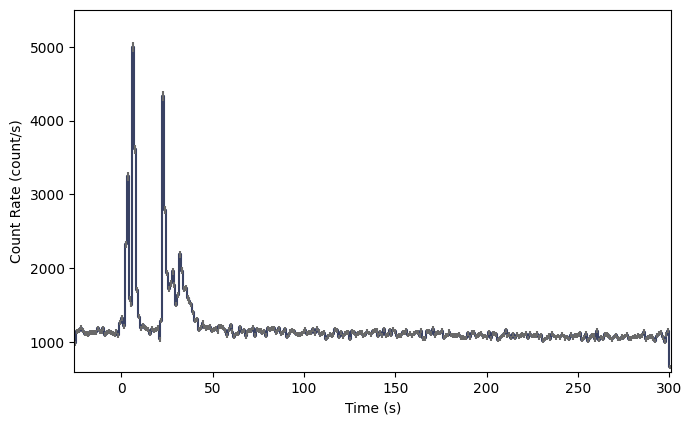

In [2]:
%matplotlib inline
from gbm.plot import Lightcurve, Spectrum

erange = (8.0, 900.0)

lc_data = phaii.to_lightcurve(energy_range=erange)
lcplot = Lightcurve(data=lc_data)

Nice looking lightcurve!  Next, we'll want to define regions outside the obvious source region to identify as background.  The TTE data early in the mission unfortunately didn't have very much pre-trigger background, but we'll try our best.  We haven't actually talked about background modeling yet, but I'll walk you through it; it's not very hard.

In [3]:
# we want two background intervals, one before and one after the source.
# by eye, let's try:
bkgd_times = [(-20.0, -5.0), (75.0, 200.0)]

The background module is in ```gbm.background```, and similar to the binning algorithms, background modeling algorithms can be divded between binned and unbinned data.  Now TTE data *is* temporally unbinned, but for simplicitly let's use an algorithm for pre-binned data.  In fact we'll use the same polynomial background algorithm that [RMfit](https://fermi.gsfc.nasa.gov/ssc/data/analysis/rmfit/) uses.

In [4]:
# the background fitter interface
from gbm.background import BackgroundFitter
# our fitting algorithm
from gbm.background.binned import Polynomial

# we initialize our background fitter with the phaii object, the algorithm, and the time ranges to fit.
# if we were using an unbinned algorithm, we'd call .from_tte() and give it tte instead of phaii
backfitter = BackgroundFitter.from_phaii(phaii, Polynomial, time_ranges=bkgd_times)

# and once initialized, we can run the fit with the fitting parameters appropriate for our algorithm.
# here, we'll do a 1st order polynomial
backfitter.fit(order=1)


Ok, the fit is done, but how do we know if it is a good fit?  You can return the fit statistic and degrees-of-freedom (DoF) for each energy channel fit, and try to figure out if it's a good fit based on that (Note: not always the best way to go).

In [5]:
backfitter.statistic/backfitter.dof

array([1.05253464, 0.97225381, 0.91227241, 0.98050048, 0.84681665,
       1.0109339 , 0.83987198, 0.99393676, 0.93546538, 0.97676709,
       1.06159651, 1.13014594, 1.02241299, 0.87300405, 0.93111584,
       0.77749972, 0.88585415, 1.24709709, 1.00078239, 1.18972735,
       1.08504497, 0.86004   , 1.09627527, 1.26029689, 1.02805267,
       1.09511262, 1.09453753, 0.84877554, 1.03829697, 1.18797705,
       1.17876657, 1.0435771 , 0.87277942, 1.1235214 , 0.75154049,
       1.16525405, 0.96174605, 0.86952962, 1.05345248, 1.06671789,
       0.98715977, 0.87106808, 0.81729816, 1.01830519, 0.96619755,
       0.96130275, 1.26006097, 1.10956129, 0.7465444 , 1.14112326,
       1.17921618, 0.99306683, 0.94085532, 0.75801103, 0.93522882,
       0.93297998, 1.34048725, 0.97457337, 0.92851687, 1.13544663,
       1.03582596, 0.86974828, 0.95736557, 0.90115499, 0.97121474,
       0.99067311, 1.03314964, 1.05197093, 0.67085108, 0.86989996,
       1.13958071, 0.79637932, 0.83125611, 0.96961894, 0.70648

You can also plot it.  If you want to plot the background model, it's a good idea to plot it not just during the background segments you fit, but also during the source interval. This is important because you want to see how well the background is modeled *during* the source interval.  This means that the model needs to be interpolated over the source interval. For simplicity, and to make the background look smooth, we'll go ahead and interpolate across every time bin in the lightcurve:

In [6]:
bkgd = backfitter.interpolate_bins(phaii.data.tstart, phaii.data.tstop)
type(bkgd)

gbm.background.background.BackgroundRates

So what is ```bkgd```?  It's similar to the same data structure that contains the PHAII data: a 2D Time-Energy histogram, but instead of containing observed counts, it contains the modeled background rates for each time bin and energy channel.  So if we want to plot the background model on our lightcurve, we need to integrate over energy.  Reminder: we don't want to integrate over *all* energy channels, only the ones we set in `erange`.


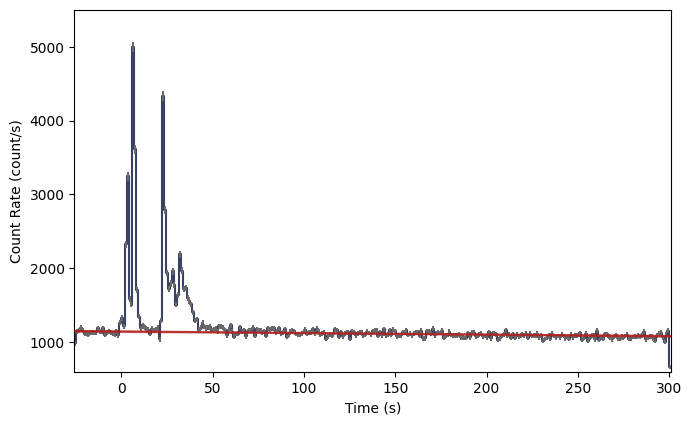

In [7]:
lc_bkgd = bkgd.integrate_energy(*erange)
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)

And look at that! The red line shows our background model interpolated at each lightcurve bin.  If you find your fit to be unacceptable, you can try refitting with a different polynomial order like this:
```python
backfitter.fit(order=2)
```
Or you can try adjusting the background selection ranges.

Now, we are currently viewing the full time-extent of the data in the file, but if we want to identify a particular time interval for analysis, it's kind of hard when we're zoomed out so far.  So you should zoom in appropriately:

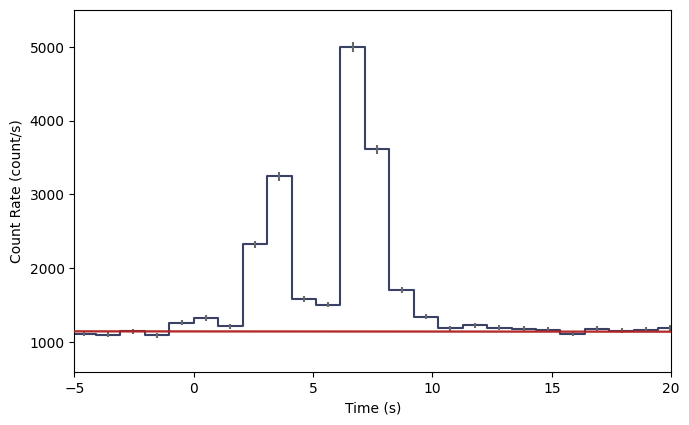

In [8]:
lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
# zoom in to 5 seconds before to 20 s after the trigger time
view_range = (-5.0, 20.0)
lcplot.xlim = view_range

Now, we need to define a time interval of interest.  It could be a single bin, or it could be multiple bins.  Let's select the brightest two bins in this view.

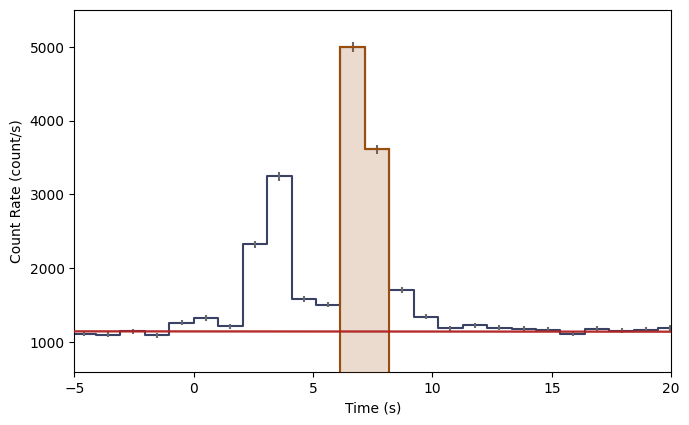

In [9]:
# our lightcurve source selection
src_time = (7.0, 8.0)
src_lc = phaii.to_lightcurve(time_range=src_time, energy_range=erange)

lcplot = Lightcurve(data=lc_data, background=lc_bkgd)
lcplot.add_selection(src_lc)
lcplot.xlim = view_range

The orange shading indicates the time bins you've selected as source signal.  You can also make a plot of the count spectrum during the selection to see what the background model looks like in comparison to the data:

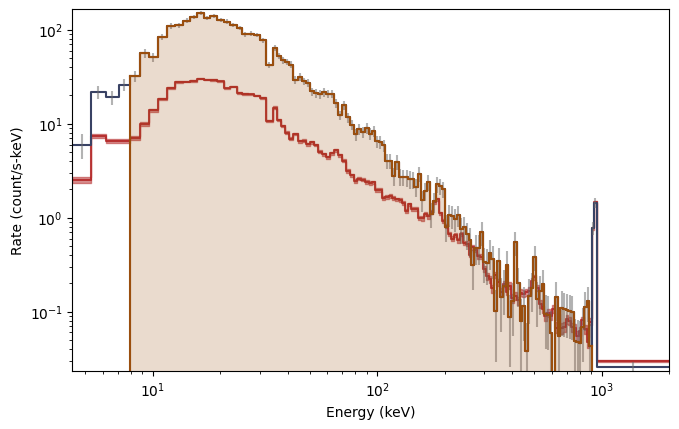

In [10]:
# the observed count spectrum during the source selection
spec_data = phaii.to_spectrum(time_range=src_time)
# the background model integrated over the source selection time
spec_bkgd = bkgd.integrate_time(*src_time)
# and the energy range selection that was made
spec_selection = phaii.to_spectrum(time_range=src_time, energy_range=erange)

specplot = Spectrum(data=spec_data, background=spec_bkgd)
specplot.add_selection(spec_selection)

And there you have it!  The background model, integrated over the source window, as a function of energy is red, while the orange shaded region indicates the part of the spectrum you're interested in.

If we are satisifed with everything we've done, it's now time to export our selections. XSPEC uses PHA and BAK files containing a single observed count spectrum and the background model during the exposure of the spectrum, respectively.  To get from where we are to where we need to be, it is really just two function calls:

In [11]:
# the single-spectrum PHA object over our source time interval and energy range
pha = phaii.to_pha(time_ranges=src_time, energy_range=erange) 

# the background spectrum
bak = bkgd.to_bak(time_range=src_time)

type(pha), type(bak)

(gbm.data.pha.PHA, gbm.data.pha.BAK)

So now you have a PHA and BAK object which can be written as fully-formed FITS files using the `.write()` methods:
```python
bak.write('./', filename='my_first_custom.bak')
pha.write('./', filename='my_first_custom.pha', backfile='my_first_custom.bak')
```
You can omit the `filename` keywords if the default naming convention is good enough for you (although beware of naming conflicts if you are writing multiple files from one event). The `backfile` keyword is necessary if you want to use the PHA and BAK files in XSPEC.

Now there is one thing missing; we forgot about the response file!  You can't do any spectral fitting without the response.

In [12]:
from gbm.data import RSP
rsp = RSP.open(test_data_dir+'/glg_cspec_n9_bn090131090_v00.rsp2')

This is an RSP2 file, meaning that it is a time sequence of DRMs.  We want to choose the DRM that is most appropriate for our time selection.  We have a couple of options: we could simply return the DRM that is closest to our interval of interest, or we can interpolate the time series of DRMs to provide a response at the time of our interval (more specifically at the center of our time interval).

In [13]:
# the DRM that is nearest to our time of interest
nearest_drm = rsp.extract_drm(atime=pha.tcent)

# the interpolated DRM
interp_drm = rsp.interpolate(pha.tcent)

Choose one, and you can write it to a file just like the PHA and BAK:
```python
interp_drm.write('./', filename='my_first_custom.rsp')
```

We're done!  You have successfully exported your source selection, background model, and an appropriate detector response. Looking back, it may seem like we've done a lot, but most of the commands we issued were for the sake of plotting!  Once you're more familiar with the workflow, you don't have to make quite so many plots along the way.

In any case, you can now XSPEC to your heart's content!

Of course, maybe XSPEC isn't your thing.  That's alright, too.  In fact, the GBM Data Tools have the functionality to perform maximum likelihood fits of the spectra, and if you are interested, [continue on!](./SpectralFitting.ipynb)